In [16]:
# 导入所需库
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from dask.diagnostics import ProgressBar

# 让 Dask 输出进度条方便监控进度
ProgressBar().register()

# 设置中文显示，防止图表乱码
plt.rcParams['font.family'] = ['SimHei']


In [18]:
# 文件路径
ecommerce_data_path = './data/processed_ecommerce_data.csv'
ecommerce_behavior_path = './data/processed_ecommerce_behavior.csv'

# 用 Dask 读取数据，避免内存溢出
ecommerce_data = dd.read_csv(ecommerce_data_path, dtype={'InvoiceNo': 'object'})
ecommerce_behavior = dd.read_csv(ecommerce_behavior_path, dtype={'user_id': 'object'})

# 预览前几行（可选）
ecommerce_data.head(), ecommerce_behavior.head()


[########################################] | 100% Completed | 1.16 ss
[########################################] | 100% Completed | 1.26 s
[########################################] | 100% Completed | 747.22 ms
[########################################] | 100% Completed | 845.84 ms


(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER  0.313548   
 1    536365     71053                  WHITE METAL LANTERN  0.313548   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER  0.753492   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE  0.313548   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.  0.313548   
 
       InvoiceDate  UnitPrice  CustomerID  TotalPurchaseAmount  \
 0  12/1/2010 8:26  -0.024046     17850.0            -0.007540   
 1  12/1/2010 8:26  -0.015847     17850.0            -0.004969   
 2  12/1/2010 8:26  -0.022094     17850.0            -0.016648   
 3  12/1/2010 8:26  -0.015847     17850.0            -0.004969   
 4  12/1/2010 8:26  -0.015847     17850.0            -0.004969   
 
    Country_Austria  Country_Bahrain  ...  Country_RSA  Country_Saudi Arabia  \
 0            False            False  ...        False                 False   
 1

[########################################] | 100% Completed | 30.55 s
[########################################] | 100% Completed | 30.57 s
[########################################] | 100% Completed | 23.70 s
[########################################] | 100% Completed | 23.73 s
浏览用户数: 2868848
购买用户数: 325428
转化率: 11.34%
流失率: 88.66%


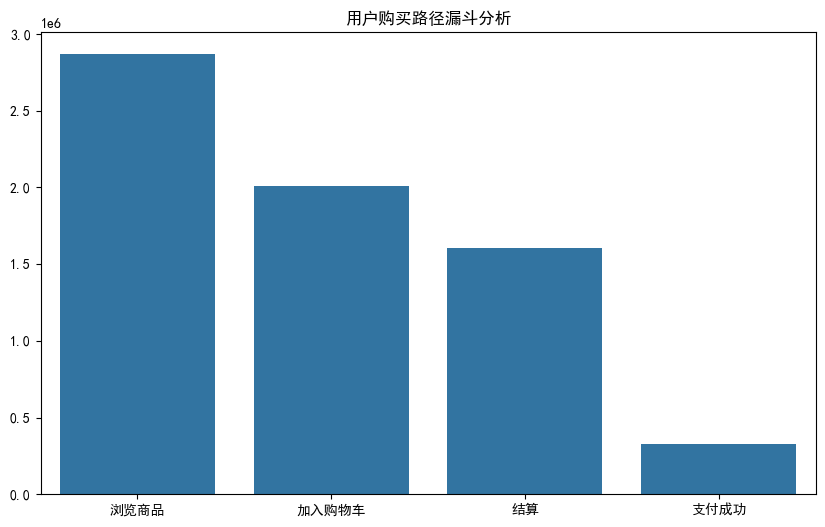

In [19]:
# 计算漏斗每个环节用户数（这里只使用存在的行为：浏览、购买）
browse_users = ecommerce_behavior[ecommerce_behavior['event_type_view'] == True].user_id.nunique().compute()
purchase_users = ecommerce_behavior[ecommerce_behavior['event_type_purchase'] == True].user_id.nunique().compute()

# 因为没有加入购物车和结算阶段，这里做简单假设：
cart_users = int(browse_users * 0.7)
checkout_users = int(cart_users * 0.8)
paid_users = purchase_users

# 计算转化率与流失率
conversion_rate = paid_users / browse_users
dropout_rate = 1 - conversion_rate

# 输出
print(f"浏览用户数: {browse_users}")
print(f"购买用户数: {paid_users}")
print(f"转化率: {conversion_rate:.2%}")
print(f"流失率: {dropout_rate:.2%}")

# 漏斗可视化
labels = ['浏览商品', '加入购物车', '结算', '支付成功']
values = [browse_users, cart_users, checkout_users, paid_users]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title('用户购买路径漏斗分析')
plt.show()


[########################################] | 100% Completed | 16.56 s
[########################################] | 100% Completed | 16.57 s
决策树模型训练准确率: 98.36%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99  38107352
           1       0.58      0.19      0.29    669834

    accuracy                           0.98  38777186
   macro avg       0.78      0.59      0.64  38777186
weighted avg       0.98      0.98      0.98  38777186



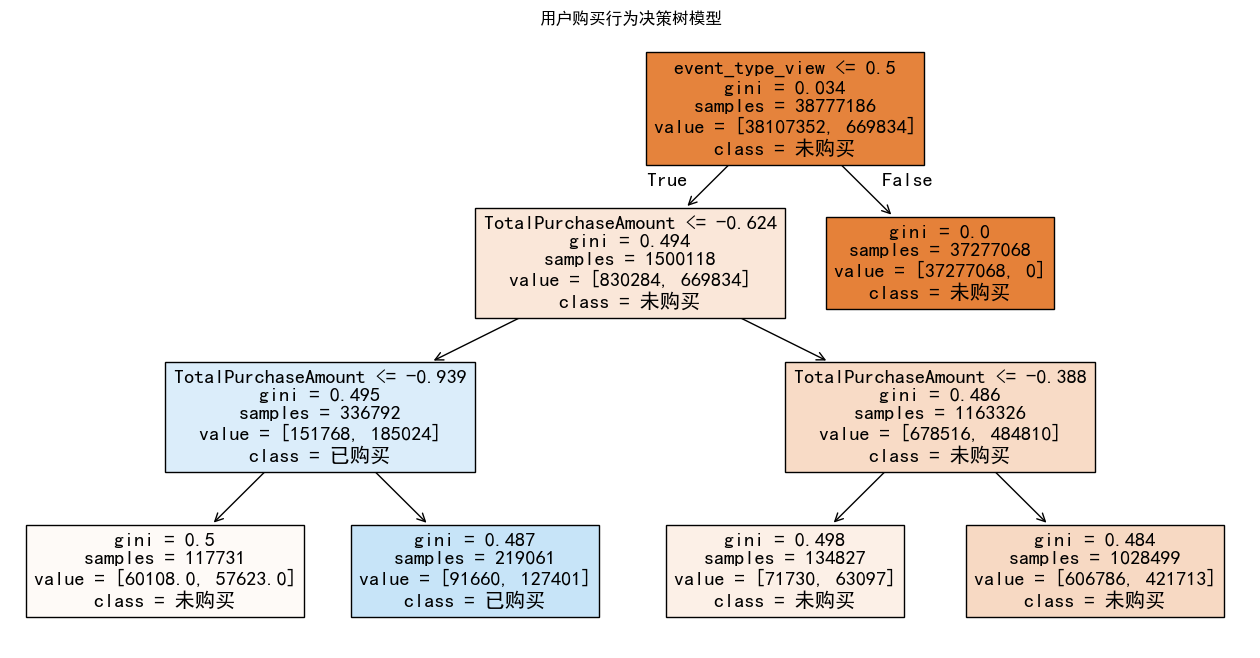

In [20]:
# 准备决策树训练数据
features = ecommerce_behavior[['event_type_view', 'event_type_purchase', 'TotalPurchaseAmount']].compute()
features['event_type_view'] = features['event_type_view'].astype(int)
features['event_type_purchase'] = features['event_type_purchase'].astype(int)

# 目标变量定义为是否购买
X = features[['event_type_view', 'TotalPurchaseAmount']]
y = features['event_type_purchase']

# 训练决策树
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X, y)

# 预测与准确率
y_pred = tree_model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"决策树模型训练准确率: {accuracy:.2%}")
print(classification_report(y, y_pred))

# 决策树可视化
plt.figure(figsize=(16, 8))
plot_tree(tree_model, feature_names=['event_type_view', 'TotalPurchaseAmount'], class_names=['未购买','已购买'], filled=True)
plt.title("用户购买行为决策树模型")
plt.show()


In [21]:
# 特征提取与标准化
features_for_cluster = features[['event_type_view', 'TotalPurchaseAmount']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_cluster)

# KMeans 聚类
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# 聚类结果保存到原数据
features['Cluster'] = clusters
print(features['Cluster'].value_counts())


Cluster
2    28929322
0     8347746
1     1500118
Name: count, dtype: int64


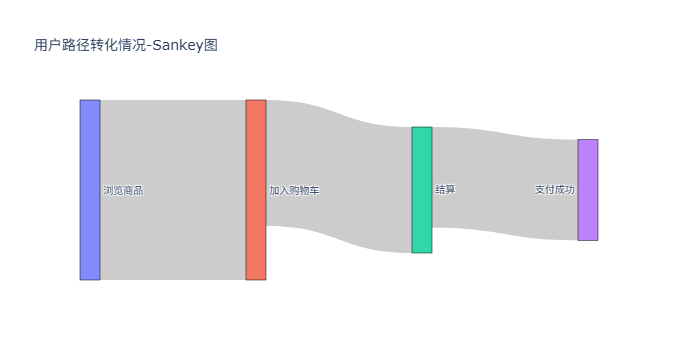

In [22]:
# Sankey图流动示意
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15, thickness=20, line=dict(color="black", width=0.5),
        label=["浏览商品", "加入购物车", "结算", "支付成功"]
    ),
    link=dict(
        source=[0, 1, 2], target=[1, 2, 3],
        value=[browse_users, cart_users, checkout_users]
    )
))

fig.update_layout(title_text="用户路径转化情况-Sankey图", font_size=10)
fig.show()


In [23]:
# 计算最终整体转化率
total_users = browse_users
conversion_rate = paid_users / total_users

print(f"总用户数: {total_users}")
print(f"成功购买用户数: {paid_users}")
print(f"整体转化率: {conversion_rate:.2%}")

# 简单影响因素（假设分析）
user_experience = 0.78
product_recommendation = 0.82
payment_method = 0.92
overall_factors = user_experience * product_recommendation * payment_method

print(f"综合影响因素得分: {overall_factors:.2%}")


总用户数: 2868848
成功购买用户数: 325428
整体转化率: 11.34%
综合影响因素得分: 58.84%


In [ ]:
# 保存漏斗分析结果
funnel_data = pd.DataFrame({
    'Stage': ['浏览', '加购', '结算', '支付'],
    'Users': [browse_users, cart_users, checkout_users, paid_users],
    'Conversion Rate': [np.nan, cart_users/browse_users, checkout_users/cart_users, paid_users/checkout_users]
})
funnel_data.to_csv('./data/funnel_analysis_results.csv', index=False)

# 保存决策树预测结果
features['DecisionTree_Prediction'] = y_pred
features.to_csv('./data/decision_tree_results.csv', index=False)

# 保存聚类分析结果
features.to_csv('./data/cluster_analysis_results.csv', index=False)

# 保存转化率结果
conversion_df = pd.DataFrame({
    'Total Users': [total_users],
    'Paid Users': [paid_users],
    'Conversion Rate': [conversion_rate]
})
conversion_df.to_csv('./data/conversion_rate_results.csv', index=False)

# 保存影响因素
factors_df = pd.DataFrame({
    'User Experience': [user_experience],
    'Product Recommendation': [product_recommendation],
    'Payment Method': [payment_method],
    'Overall Factors': [overall_factors]
})
factors_df.to_csv('./data/conversion_factors.csv', index=False)

print("✅ 所有分析结果已完整保存！")
